<a href="https://colab.research.google.com/github/Weeraton/Improved-Thai-Handwritten-Text-Recognition-In-CRNN/blob/main/CNN_RNN_Vanila_on.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip
!a
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

/bin/bash: a: command not found


In [9]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


In [10]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

In [11]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [12]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [13]:
train_labels2 = []
max_len = 0

for label in train_samples:
    label2 = label.split(" ")[-1].strip()
    if(len(label2) > 4):
      train_labels2.append(label)



train_samples =train_labels2
print(f"Total training samples: {len( train_samples)}")

Total training samples: 31452


In [14]:
base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [15]:
train_labels_cleaned = []
characters = set()
max_len = 0
min_len = 100
for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    min_len = min(max_len, len(label))
    train_labels_cleaned.append(label)

print("Maximum length: ", max_len)
print("Minimum length: ", min_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  21
Minimum length:  10
Vocab size:  70


['during',
 'booty',
 'gastronomy',
 'flying',
 'presented',
 'items',
 'sedate',
 'compelled',
 'several',
 'families']

In [16]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [18]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [19]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [20]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

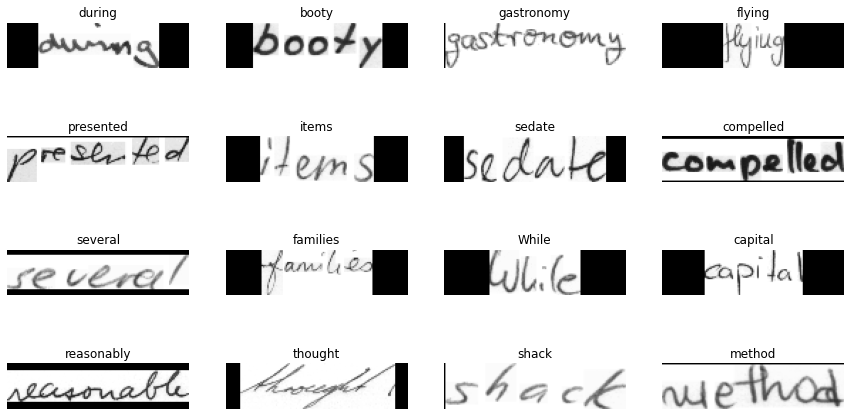

In [21]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

In [22]:
#  2.4651 - val_loss: 2.5315
# Mean edit distance for epoch 46: 17.6239

In [23]:
early_stopping_patience = 50
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

In [24]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
        self.ignore_longer_outputs_than_inputs=True
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    ### 2D Self-Attention ###
    # x = keras.layers.MultiHeadAttention(num_heads=2, key_dim=2)(x,x)


    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.

    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)
   
    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)


    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model



# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 128, 32, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 32, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 64, 16, 32)   0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 64, 16, 64)   18496       pool1[0][0]                      
_____________________________________________________________________________

In [25]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [26]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [27]:

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

In [ ]:
epochs = 50  # To get good results this should be at least 50.


# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)

Epoch 1/30
492/492 [==============================] - 324s 650ms/step - loss: 23.5584 - val_loss: 15.2570
Mean edit distance for epoch 1: 20.9994
Epoch 2/30
492/492 [==============================] - 299s 608ms/step - loss: 21.4297 - val_loss: 14.5580
Mean edit distance for epoch 2: 20.5666
Epoch 3/30
492/492 [==============================] - 306s 621ms/step - loss: 19.6268 - val_loss: 12.8705
Mean edit distance for epoch 3: 20.5405
Epoch 4/30
492/492 [==============================] - 303s 615ms/step - loss: 17.8519 - val_loss: 12.1029
Mean edit distance for epoch 4: 20.3991
Epoch 5/30
492/492 [==============================] - 304s 618ms/step - loss: 16.4159 - val_loss: 11.2544
Mean edit distance for epoch 5: 20.2120
Epoch 6/30
492/492 [==============================] - 302s 613ms/step - loss: 14.9579 - val_loss: 10.2699
Mean edit distance for epoch 6: 19.8122
Epoch 7/30
492/492 [==============================] - 305s 620ms/step - loss: 13.3171 - val_loss: 9.3778
Mean edit distance 

Epoch 1/50
1357/1357 [==============================] - 872s 637ms/step - loss: 13.7627 - val_loss: 12.1978
Mean edit distance for epoch 1: 20.4784
Epoch 2/50
1357/1357 [==============================] - 807s 595ms/step - loss: 11.3531 - val_loss: 10.2605
Mean edit distance for epoch 2: 20.1812
Epoch 3/50
1357/1357 [==============================] - 813s 599ms/step - loss: 9.6770 - val_loss: 8.7144
Mean edit distance for epoch 3: 19.9340
Epoch 4/50
1357/1357 [==============================] - 810s 597ms/step - loss: 8.3410 - val_loss: 7.2039
Mean edit distance for epoch 4: 19.5045
Epoch 5/50
1357/1357 [==============================] - 811s 598ms/step - loss: 6.9445 - val_loss: 5.6739
Mean edit distance for epoch 5: 18.8497
Epoch 6/50
1357/1357 [==============================] - 814s 600ms/step - loss: 5.7369 - val_loss: 4.5437
Mean edit distance for epoch 6: 18.3769
Epoch 7/50
1357/1357 [==============================] - 812s 599ms/step - loss: 4.8900 - val_loss: 3.8967
Mean edit distance for epoch 7: 18.1234
Epoch 8/50
1357/1357 [==============================] - 814s 600ms/step - loss: 4.3543 - val_loss: 3.4385
Mean edit distance for epoch 8: 17.9284
Epoch 9/50
1357/1357 [==============================] - 812s 599ms/step - loss: 3.9772 - val_loss: 3.2063
Mean edit distance for epoch 9: 17.8982
Epoch 10/50
1357/1357 [==============================] - 807s 595ms/step - loss: 3.6751 - val_loss: 2.9815
Mean edit distance for epoch 10: 17.8062
Epoch 11/50
1357/1357 [==============================] - 808s 595ms/step - loss: 3.4625 - val_loss: 2.9122
Mean edit distance for epoch 11: 17.7735
Epoch 12/50
1357/1357 [==============================] - 810s 597ms/step - loss: 3.2657 - val_loss: 2.7347
Mean edit distance for epoch 12: 17.7467
Epoch 13/50
1357/1357 [==============================] - 809s 596ms/step - loss: 3.1176 - val_loss: 2.7052
Mean edit distance for epoch 13: 17.7332
Epoch 14/50
1357/1357 [==============================] - 812s 598ms/step - loss: 2.9892 - val_loss: 2.5579
Mean edit distance for epoch 14: 17.6722
Epoch 15/50
1357/1357 [==============================] - 815s 601ms/step - loss: 2.8751 - val_loss: 2.4128
Mean edit distance for epoch 15: 17.6384
Epoch 16/50
1357/1357 [==============================] - 814s 600ms/step - loss: 2.7685 - val_loss: 2.3425
Mean edit distance for epoch 16: 17.5668
Epoch 17/50
1357/1357 [==============================] - 812s 598ms/step - loss: 2.6780 - val_loss: 2.2638
Mean edit distance for epoch 17: 17.5537
Epoch 18/50
1357/1357 [==============================] - 811s 598ms/step - loss: 2.5937 - val_loss: 2.3609
Mean edit distance for epoch 18: 17.6197
Epoch 19/50
1357/1357 [==============================] - 814s 600ms/step - loss: 2.5318 - val_loss: 2.1526
Mean edit distance for epoch 19: 17.5270
Epoch 20/50
1357/1357 [==============================] - 814s 600ms/step - loss: 2.4675 - val_loss: 2.1673
Mean edit distance for epoch 20: 17.5243
Epoch 21/50
1357/1357 [==============================] - 814s 600ms/step - loss: 2.4057 - val_loss: 2.1408
Mean edit distance for epoch 21: 17.5106
Epoch 22/50
1357/1357 [==============================] - 814s 600ms/step - loss: 2.3479 - val_loss: 2.0916
Mean edit distance for epoch 22: 17.4780
Epoch 23/50
1357/1357 [==============================] - 814s 600ms/step - loss: 2.2925 - val_loss: 2.0858
Mean edit distance for epoch 23: 17.4811
Epoch 24/50
1357/1357 [==============================] - 815s 601ms/step - loss: 2.2561 - val_loss: 2.0693
Mean edit distance for epoch 24: 17.4733
Epoch 25/50
1357/1357 [==============================] - 812s 598ms/step - loss: 2.2162 - val_loss: 1.9694
Mean edit distance for epoch 25: 17.4195
Epoch 26/50
1357/1357 [==============================] - 812s 598ms/step - loss: 2.1627 - val_loss: 1.9731
Mean edit distance for epoch 26: 17.4329
Epoch 27/50
1357/1357 [==============================] - 810s 597ms/step - loss: 2.1446 - val_loss: 1.9606
Mean edit distance for epoch 27: 17.4449
Epoch 28/50
1357/1357 [==============================] - 822s 606ms/step - loss: 2.0957 - val_loss: 1.9769
Mean edit distance for epoch 28: 17.4341
Epoch 29/50
1357/1357 [==============================] - 812s 598ms/step - loss: 2.0726 - val_loss: 1.9213
Mean edit distance for epoch 29: 17.4178
Epoch 30/50
1357/1357 [==============================] - 815s 601ms/step - loss: 2.0455 - val_loss: 1.9200
Mean edit distance for epoch 30: 17.4092
Epoch 31/50
1357/1357 [==============================] - 813s 599ms/step - loss: 2.0118 - val_loss: 1.8677
Mean edit distance for epoch 31: 17.4274
Epoch 32/50
1357/1357 [==============================] - 811s 598ms/step - loss: 1.9898 - val_loss: 1.9136
Mean edit distance for epoch 32: 17.4260
Epoch 33/50
1357/1357 [==============================] - 821s 605ms/step - loss: 1.9685 - val_loss: 1.8362
Mean edit distance for epoch 33: 17.3760
Epoch 34/50
1357/1357 [==============================] - 815s 600ms/step - loss: 1.9354 - val_loss: 1.8339
Mean edit distance for epoch 34: 17.3862
Epoch 35/50
1357/1357 [==============================] - 814s 600ms/step - loss: 1.9006 - val_loss: 1.8429
Mean edit distance for epoch 35: 17.3876
Epoch 36/50
1357/1357 [==============================] - 816s 602ms/step - loss: 1.8864 - val_loss: 1.8326
Mean edit distance for epoch 36: 17.3735
Epoch 37/50
1357/1357 [==============================] - 798s 588ms/step - loss: 1.8947 - val_loss: 1.8331
Mean edit distance for epoch 37: 17.3654
Epoch 38/50
1357/1357 [==============================] - 813s 599ms/step - loss: 1.8548 - val_loss: 1.8152
Mean edit distance for epoch 38: 17.3530
Epoch 39/50
1357/1357 [==============================] - 818s 603ms/step - loss: 1.8383 - val_loss: 1.8059
Mean edit distance for epoch 39: 17.3746
Epoch 40/50
1357/1357 [==============================] - 814s 600ms/step - loss: 1.8190 - val_loss: 1.7721
Mean edit distance for epoch 40: 17.3437
Epoch 41/50
1357/1357 [==============================] - 815s 601ms/step - loss: 1.7837 - val_loss: 1.7625
Mean edit distance for epoch 41: 17.3608
Epoch 42/50
1357/1357 [==============================] - 810s 597ms/step - loss: 1.7713 - val_loss: 1.8075
Mean edit distance for epoch 42: 17.3597
Epoch 43/50
1357/1357 [==============================] - 808s 596ms/step - loss: 1.7641 - val_loss: 1.7402
Mean edit distance for epoch 43: 17.3410
Epoch 44/50
1357/1357 [==============================] - 811s 597ms/step - loss: 1.7590 - val_loss: 1.7069
Mean edit distance for epoch 44: 17.3302
Epoch 45/50
1357/1357 [==============================] - 812s 599ms/step - loss: 1.7356 - val_loss: 1.7925
Mean edit distance for epoch 45: 17.3513
Epoch 46/50
1357/1357 [==============================] - 811s 598ms/step - loss: 1.7105 - val_loss: 1.7815
Mean edit distance for epoch 46: 17.3529
Epoch 47/50
1357/1357 [==============================] - 803s 592ms/step - loss: 1.7029 - val_loss: 1.7361
Mean edit distance for epoch 47: 17.3321
Epoch 48/50
1357/1357 [==============================] - 797s 587ms/step - loss: 1.6786 - val_loss: 1.7533
Mean edit distance for epoch 48: 17.3293
Epoch 49/50
1357/1357 [==============================] - 801s 590ms/step - loss: 1.6566 - val_loss: 1.7349
Mean edit distance for epoch 49: 17.3450
Epoch 50/50
1357/1357 [==============================] - 799s 589ms/step - loss: 1.6442 - val_loss: 1.7651
Mean edit distance for epoch 50: 17.3498

In [ ]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [ ]:
 fig, (ax1) = plt.subplots ( figsize=(30, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(2, 14, 1))


legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Project Kmitl/CNN-RNN')